<a href="https://colab.research.google.com/github/Grashch/Data-science/blob/main/TreeRegressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
import numpy as np
import pandas as pd

In [21]:
data = pd.read_csv('/content/flavors_of_cacao.csv')
data = data.rename(columns={
    'Company\xa0\n(Maker-if known)': 'Company (Maker-if known)',
    'Specific Bean Origin\nor Bar Name': 'Specific Bean Origin or Bar Name',
    'Review\nDate' : 'Review Date',
    'Cocoa\nPercent' : 'Cocoa Percent',
    'Company\nLocation' : 'Company Location',
    'Bean\nType' : 'Bean Type',
    'Broad Bean\nOrigin' : 'Broad Bean Origin'
})
data['Cocoa Percent'] = data['Cocoa Percent'].str.replace('%', '').astype(float)
data.head()

,Company (Maker-if known),Specific Bean Origin or Bar Name,REF,Review Date,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,A. Morin,Agua Grande,1876,2016,63.0,France,3.75,,Sao Tome
1,A. Morin,Kpime,1676,2015,70.0,France,2.75,,Togo
2,A. Morin,Atsane,1676,2015,70.0,France,3.00,,Togo
3,A. Morin,Akata,1680,2015,70.0,France,3.50,,Togo
4,A. Morin,Quilla,1704,2015,70.0,France,3.50,,Peru


In [22]:
data.isna().mean(axis=0)

,0
Company (Maker-if known),0.000000
Specific Bean Origin or Bar Name,0.000000
REF,0.000000
Review Date,0.000000
Cocoa Percent,0.000000
Company Location,0.000000
Rating,0.000000
Bean Type,0.000557
Broad Bean Origin,0.000557


In [23]:
categorical_features = []
numerical_features = []
[col for col in data.columns if data[col].dtype == "object"]

['Company (Maker-if known)',
 'Specific Bean Origin or Bar Name',
 'Company Location',
 'Bean Type',
 'Broad Bean Origin']

In [24]:
company_stat = data['Company (Maker-if known)'].value_counts()
company_stat

,count
Company (Maker-if known),
Soma,47
Bonnat,27
Fresco,26
Pralus,25
A. Morin,23
...,...
Svenska Kakaobolaget,1
Baravelli's,1
Urzi,1


In [25]:
data['company'] = data['Company (Maker-if known)'].apply(lambda x: x if company_stat[x] >= 18 else 'Other')
data['company'].value_counts()

,count
company,
Other,1505
Soma,47
Bonnat,27
Fresco,26
Pralus,25
A. Morin,23
Arete,22
Guittard,22
Domori,22


In [26]:
origin_stat = data['Specific Bean Origin or Bar Name'].value_counts()
location_stat = data['Company Location'].value_counts()
type_stat = data['Bean Type'].value_counts(dropna=False)
bean_stat = data['Broad Bean Origin'].value_counts(dropna=False)

In [27]:
data['origin'] = data['Specific Bean Origin or Bar Name'].apply(lambda x: x if origin_stat[x] >= 18 else 'Other')
data['location'] = data['Company Location'].apply(lambda x: x if location_stat[x] >= 18 else 'Other')
data['bean_type'] = data['Bean Type'].apply(lambda x: x if type_stat[x] >= 20 else 'Other')
data['bean_origin'] = data['Broad Bean Origin'].apply(lambda x: x if bean_stat[x] >= 18 else 'Other')

In [28]:
categorical_features.extend(['company', 'origin', 'location', 'bean_type', 'bean_origin'])
numerical_features.extend(['REF', 'Review Date', 'Cocoa Percent'])

In [29]:
sum([data[feature].nunique() for feature in categorical_features])

70

In [30]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
encoder.fit(data[categorical_features])

OneHotEncoder()

In [31]:
categories = []
for i, feature in enumerate(categorical_features):
  categories.extend([f'{feature}:{value}' for value in encoder.categories_[i]])

categories[:5]

['company:A. Morin',
 'company:Arete',
 'company:Bonnat',
 'company:Coppeneur',
 'company:Domori']

In [32]:
data.loc[:,categories] = encoder.transform(data[categorical_features]).toarray()
data

,Company (Maker-if known),Specific Bean Origin or Bar Name,REF,Review Date,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin,company,...,bean_origin:Mexico,bean_origin:Nicaragua,bean_origin:Other,bean_origin:Papua New Guinea,bean_origin:Peru,bean_origin:Tanzania,bean_origin:Trinidad,bean_origin:Venezuela,bean_origin:Vietnam,bean_origin:
0,A. Morin,Agua Grande,1876,2016,63.0,France,3.75,,Sao Tome,A. Morin,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,A. Morin,Kpime,1676,2015,70.0,France,2.75,,Togo,A. Morin,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,A. Morin,Atsane,1676,2015,70.0,France,3.00,,Togo,A. Morin,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,A. Morin,Akata,1680,2015,70.0,France,3.50,,Togo,A. Morin,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,A. Morin,Quilla,1704,2015,70.0,France,3.50,,Peru,A. Morin,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1790,Zotter,Peru,647,2011,70.0,Austria,3.75,,Peru,Other,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1791,Zotter,Congo,749,2011,65.0,Austria,3.00,Forastero,Congo,Other,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1792,Zotter,Kerala State,749,2011,65.0,Austria,3.50,Forastero,India,Other,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1793,Zotter,Kerala State,781,2011,62.0,Austria,3.25,,India,Other,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
from sklearn.model_selection import train_test_split

features = numerical_features + categories

X = data[features]
y = data['Rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [34]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)

DecisionTreeRegressor()

In [35]:
from numpy._core.multiarray import result_type
from sklearn.metrics import mean_squared_error, mean_absolute_error

def get_score(model):
  results = []
  y_pred = model.predict(X_train)
  mse = mean_squared_error(y_train, y_pred)
  mae = mean_absolute_error(y_train, y_pred)
  results.append(['Train', mse, mae])
  y_pred = model.predict(X_test)
  mse = mean_squared_error(y_test, y_pred)
  mae = mean_absolute_error(y_test, y_pred)
  results.append(['Test', mse, mae])
  return pd.DataFrame(columns=['Type', 'MSE', 'MAE'], data=results)

In [36]:
get_score(tree)

,Type,MSE,MAE
0,Train,0.002049,0.008426
1,Test,0.346011,0.451763


In [76]:
from sklearn.model_selection import GridSearchCV

grid = {'criterion' : ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
        'max_depth' : [2, 3],
        'min_samples_leaf' : [1, 2, 3, 4]}

search = GridSearchCV(tree, grid)
search.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeRegressor(),
             param_grid={'criterion': ['squared_error', 'friedman_mse',
                                       'absolute_error', 'poisson'],
                         'max_depth': [2, 3],
                         'min_samples_leaf': [1, 2, 3, 4]})

In [77]:
search.best_params_

{'criterion': 'squared_error', 'max_depth': 2, 'min_samples_leaf': 1}

In [55]:
search.best_estimator_

DecisionTreeRegressor(criterion='poisson', max_depth=59, min_samples_leaf=16)

In [40]:
tree_search = DecisionTreeRegressor(criterion='friedman_mse', max_depth=50,
                                    min_samples_leaf=20, splitter='random')
tree_search.fit(X_train, y_train)
get_score(tree_search)

,Type,MSE,MAE
0,Train,0.185157,0.342775
1,Test,0.207481,0.362372


In [78]:
tree_search1 = DecisionTreeRegressor(**search.best_params_)
tree_search1.fit(X_train, y_train)
get_score(tree_search1)

,Type,MSE,MAE
0,Train,0.206149,0.370559
1,Test,0.218870,0.375432


In [71]:
pd.DataFrame({'feature': features,
              'importances': tree_search.feature_importances_
              }).sort_values('importances', ascending=False).iloc[:10]

,feature,importances
2,Cocoa Percent,0.254037
12,company:Other,0.167337
72,bean_origin:,0.098701
0,REF,0.093747
1,Review Date,0.052594
48,bean_type:,0.049802
65,bean_origin:Other,0.034498
27,location:Canada,0.033635
29,location:Ecuador,0.032628
21,origin:Peru,0.029988


[Text(0.5, 0.8333333333333334, 'Cocoa Percent <= 95.0\nsquared_error = 0.228\nsamples = 1256\nvalue = 3.186'),
 Text(0.25, 0.5, 'company:Other <= 0.5\nsquared_error = 0.213\nsamples = 1239\nvalue = 3.198'),
 Text(0.375, 0.6666666666666667, 'True  '),
 Text(0.125, 0.16666666666666666, 'squared_error = 0.166\nsamples = 191\nvalue = 3.395'),
 Text(0.375, 0.16666666666666666, 'squared_error = 0.214\nsamples = 1048\nvalue = 3.161'),
 Text(0.75, 0.5, 'REF <= 866.0\nsquared_error = 0.511\nsamples = 17\nvalue = 2.309'),
 Text(0.625, 0.6666666666666667, '  False'),
 Text(0.625, 0.16666666666666666, 'squared_error = 0.122\nsamples = 7\nvalue = 1.643'),
 Text(0.875, 0.16666666666666666, 'squared_error = 0.256\nsamples = 10\nvalue = 2.775')]

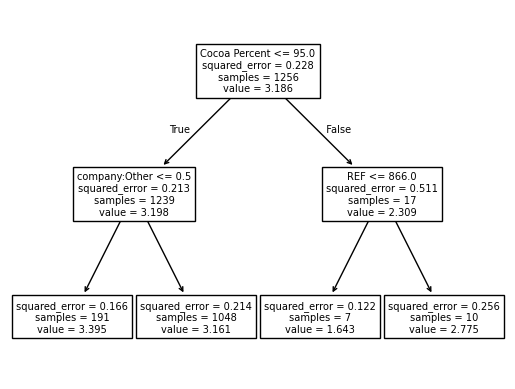

In [79]:
from sklearn.tree import plot_tree

plot_tree(tree_search1, feature_names=features)